This notebook allows you to test the retrieval API endpoints and workflow integration for the audio/video embeddings system. It demonstrates how to:

1. Upload video files to the S3 bucket for processing
2. Monitor Step Functions workflow executions
3. Test the retrieval API endpoints with different query parameters

In [99]:
import requests
import boto3
import os
import pandas as pd
import json
from PIL import Image as PILImage

region = os.environ.get("AWS_DEFAULT_REGION", "us-west-2")
ssm = boto3.client(service_name="ssm", region_name=region)
s3_client = boto3.client('s3')
sns_client = boto3.client('stepfunctions')

api_method = "POST"

def get_ssm_parameter(name):
    response = ssm.get_parameter(Name=name, WithDecryption=True)
    return response["Parameter"]["Value"]



In [ ]:
api_url = get_ssm_parameter("/videopgvector/api_retrieve")
bucket_name = get_ssm_parameter("/videopgvector/bucket_name")
state_machine_arn = get_ssm_parameter("/videopgvector/state_machine_arn")

In [95]:
# Upload Video to Amazon S3 bucket
def upload_file_to_s3 (video_path,bucket_name,s3_key):
    s3_client.upload_file(video_path, bucket_name,s3_key)
    print("Upload successful!")

base_path = "images/"

def download_file(base_path,bucket, key, filename):
    print("Download file from s3://{}{}".format(bucket,key))
    with open(base_path+filename, "wb") as data:
        s3_client.download_fileobj(bucket, key, data)
    print("Download file from s3://{}{}".format(bucket,key))
    return True

def read_image_from_s3(s3_key):
    parts = s3_key.split('s3://')[-1].split('/', 1)
    bucket_name = parts[0]
    image_key = parts[1]
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        image_data = response['Body'].read()
        return image_data
    except Exception as e:
        print(f'Error reading image from {s3_key}: {str(e)}')
        raise


In [ ]:
video_path = "<your-video-path>"
s3_key = f"video/{video_path}"
upload_file_to_s3 (video_path,bucket_name,s3_key)

Upload successful!


### Check the status of the Step Functions workflow processing your video

In [31]:
response = sns_client.describe_state_machine(
    stateMachineArn=state_machine_arn
)

In [ ]:
response = sns_client.list_executions(
    stateMachineArn=state_machine_arn,
    maxResults=12
)
response['executions'][0]

In [96]:
request_body =   {
    "query": "what is aurora"
    "", 
    "method": "retrieve",
    "k": 10
  }

response = requests.post(api_url, json=request_body)
response

<Response [200]>

In [97]:
docs = response.json().get("docs")

In [98]:
pd.DataFrame({"id": doc.get("id"),"page_content": doc.get("page_content"), **doc.get("metadata")} for doc in docs)

id  \
0  b09cc1bd-c93f-468f-8cf8-fddda0fb611c   
1  8582157a-67af-4f15-bcdd-de00f942cc0f   
2  f0865061-00e1-4884-acf0-c0c534fe1ad7   
3  6a374a4c-5ed3-43d4-bacc-cd9be8efef85   
4  1aa806ab-c735-4bf0-a5dd-76422c1cef89   
5  fc794c02-f43f-4cd7-aa96-f6cf5557886d   
6  a060ccab-c828-431f-be96-da2e4bb42b4d   
7  88d980b5-1a2d-460f-8881-cde1bf6e6e9d   
8  20d01e62-c656-4095-9f81-e6c6eb28e7a3   
9  70179630-1455-486b-a7df-e5b05ad47abf   

                                        page_content content_type  \
0  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
1  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
2  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
3  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
4  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
5  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
6  us . Got it there , yeah . 19017 Taoria . As y...         text   
7  us . Got it there , yeah . 19017 Taoria . As y...         text   
8  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
9  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   

                                              source  similarity speaker  
0  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.476201     NaN  
1  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.476201     NaN  
2  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.468831     NaN  
3  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.468831     NaN  
4  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.449074     NaN  
5  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.449074     NaN  
6  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.437820   spk_0  
7  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.437820   spk_0  
8  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.425238     NaN  
9  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.425238     NaN

In [108]:
def show_row_image_text(docs):
    for row in docs:
        if row.get("metadata").get("content_type") == "text":
            print (f"text:\n{row.get('chunks')}\nmetadata:{row.get('metadata')}\n")
        if row.get("metadata").get("content_type") == "image":
            print(row)
            sourceurl = row.get("metadata").get('source')
            print(sourceurl)
            bucket_name = sourceurl.split("/")[2] 
            key = sourceurl.replace("s3://", "").replace(bucket_name,"").lstrip("/")
            filename = sourceurl.split("/")[-1] 
            print("bucket_name: ",bucket_name)
            print("key: ",key)
            print("filename: ",filename)
            download_file(base_path,bucket_name, key, filename)
            img = PILImage.open(base_path+filename)            
            print (f"Image:\n{row.get('sourceurl')}\nmetadata:{row.get('metadata')}\n")
            display(img)

{'id': 'b09cc1bd-c93f-468f-8cf8-fddda0fb611c', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/470.jpg
filename:  470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}



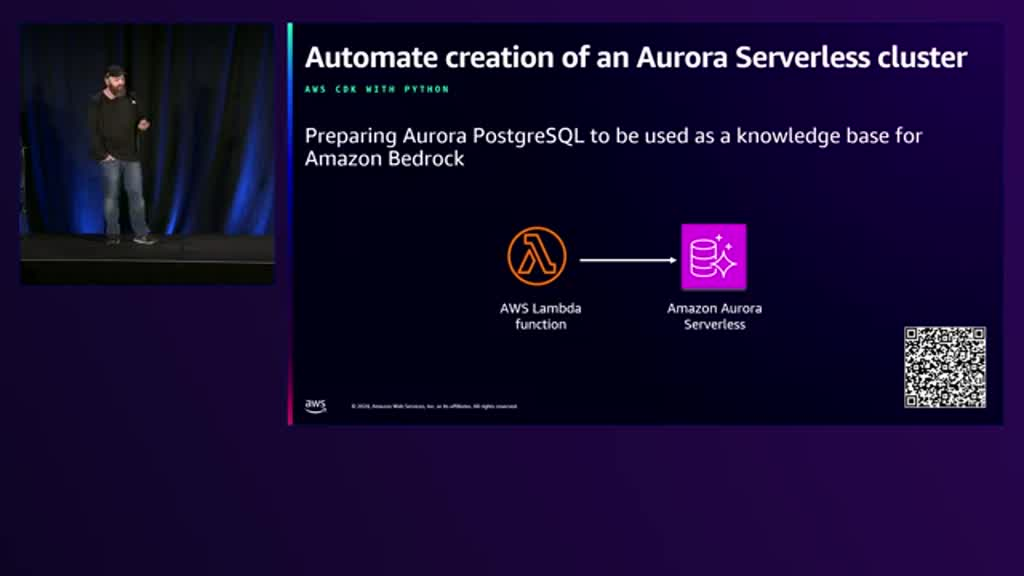

{'id': '8582157a-67af-4f15-bcdd-de00f942cc0f', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/470.jpg
filename:  470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}



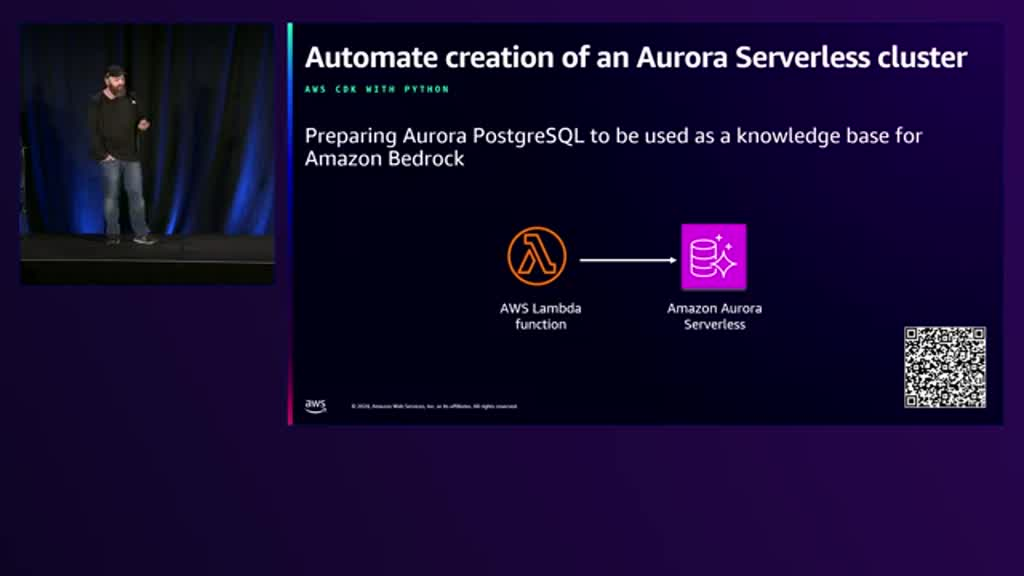

{'id': 'f0865061-00e1-4884-acf0-c0c534fe1ad7', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/429.jpg
filename:  429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}



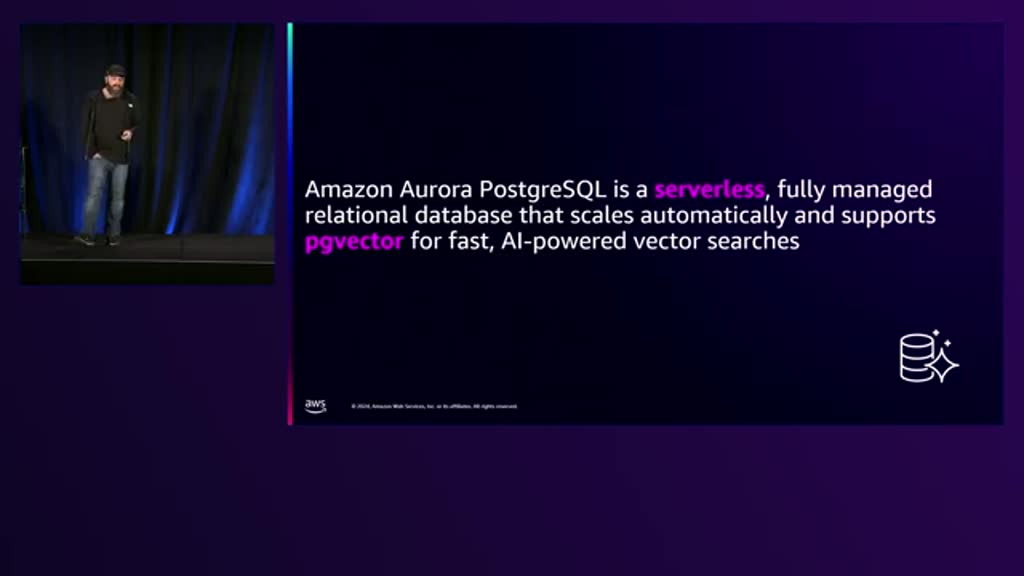

{'id': '6a374a4c-5ed3-43d4-bacc-cd9be8efef85', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/429.jpg
filename:  429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}



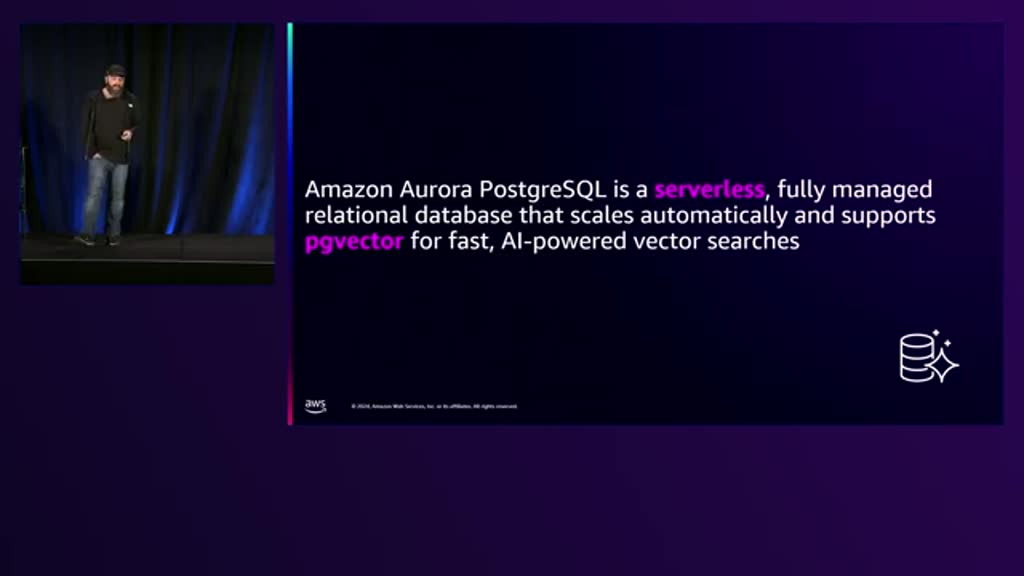

{'id': '1aa806ab-c735-4bf0-a5dd-76422c1cef89', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/600.jpg
filename:  600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}



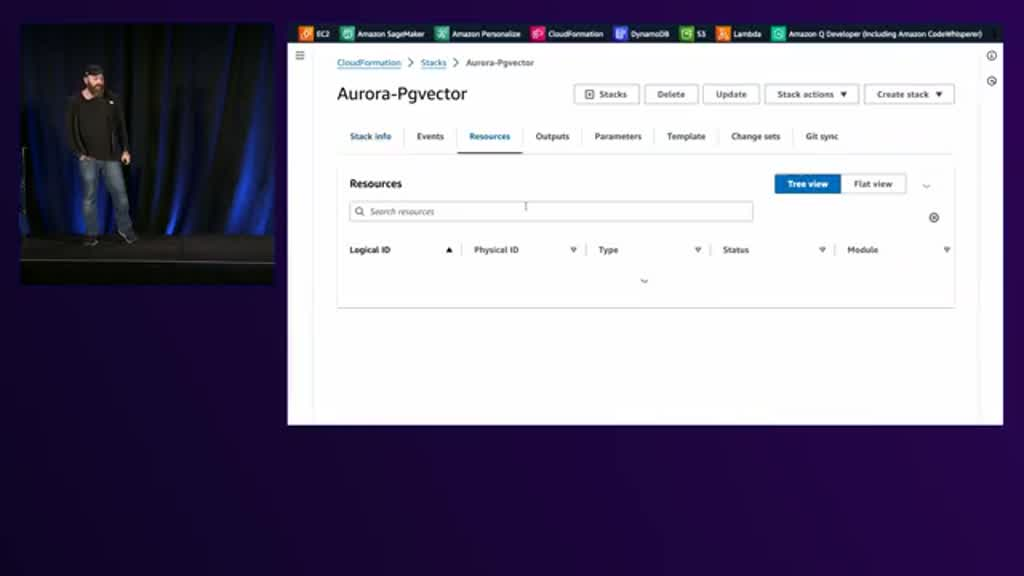

{'id': 'fc794c02-f43f-4cd7-aa96-f6cf5557886d', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/600.jpg
filename:  600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}



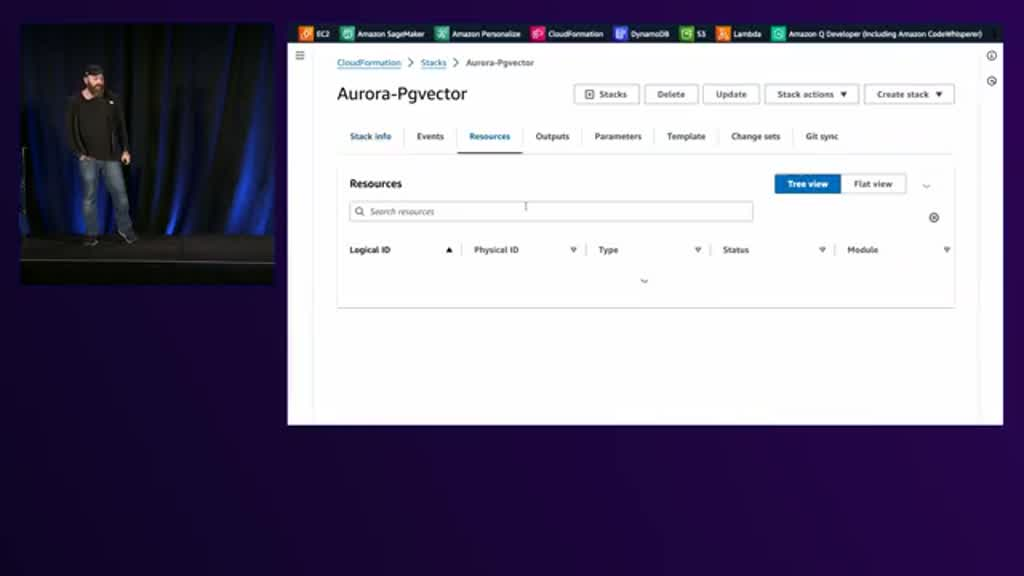

text:
None
metadata:{'speaker': 'spk_0', 'content_type': 'text', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4', 'similarity': 0.43781964749570235}

text:
None
metadata:{'speaker': 'spk_0', 'content_type': 'text', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4', 'similarity': 0.43781964749570235}

{'id': '20d01e62-c656-4095-9f81-e6c6eb28e7a3', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/2021.jpg
filename:  2021.jpg
Download file from s3://workflow-stack-videob

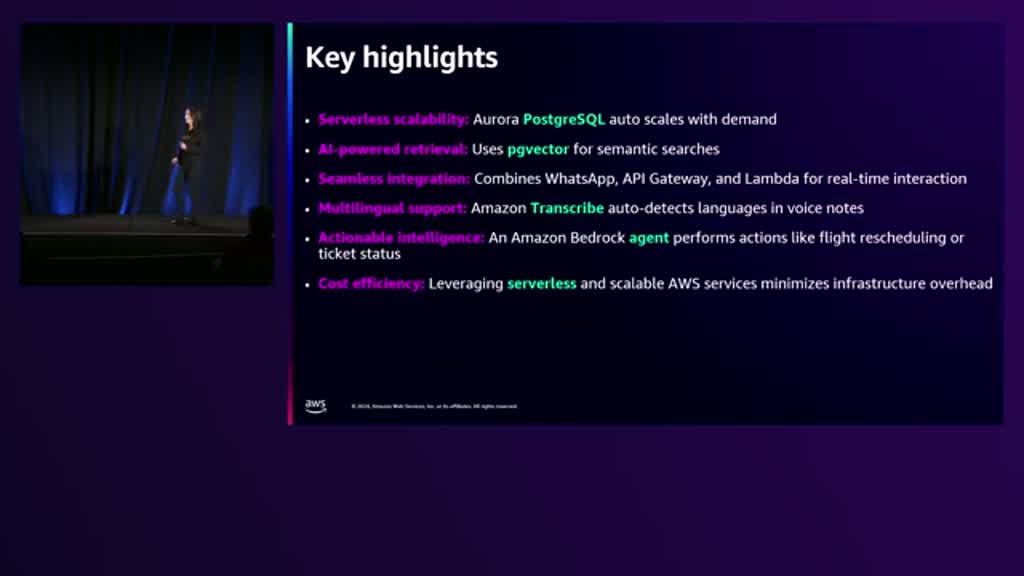

{'id': '70179630-1455-486b-a7df-e5b05ad47abf', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/2021.jpg
filename:  2021.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/2021.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/2021.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069

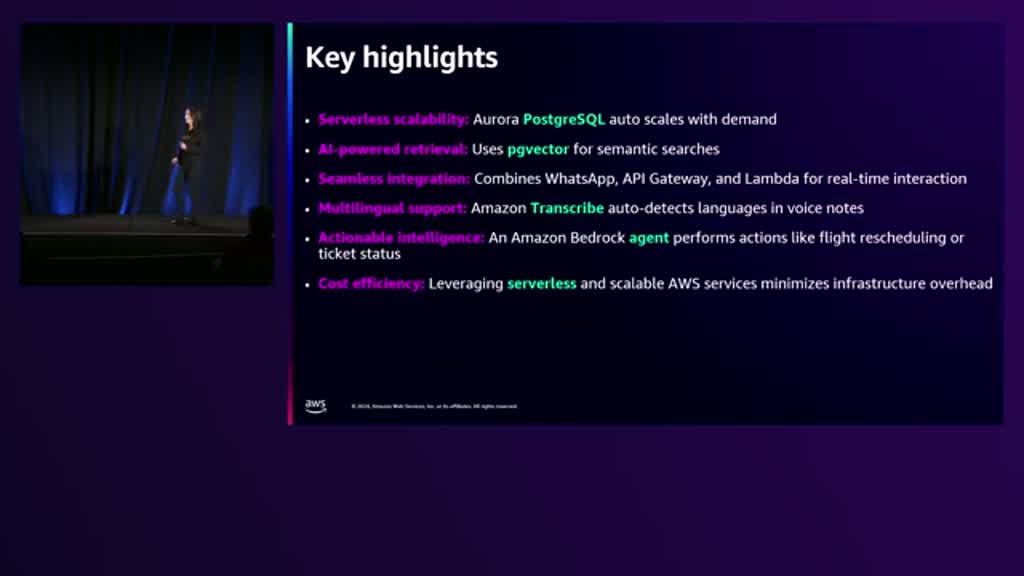

In [109]:
show_row_image_text(docs)

In [62]:
request_body =   {
    "query": "what is aurora"
    "", 
    "method": "retrieve_generate",
    "k": 10
  }

response = requests.post(api_url, json=request_body)
response

<Response [200]>

In [ ]:
docs = response.json().get("docs")

In [67]:
response.json().get('response')

'Amazon Aurora PostgreSQL is a serverless, fully managed relational database that scales automatically and supports pgvector for fast, AI-powered vector searches [2][3].'

In [86]:
value = json.loads(response.json()["docs"])


In [94]:
pd.DataFrame({"id": doc.get("id"),"page_content": doc.get("page_content"), **doc.get("metadata")} for doc in value['docs'])

id  \
0  b09cc1bd-c93f-468f-8cf8-fddda0fb611c   
1  8582157a-67af-4f15-bcdd-de00f942cc0f   
2  f0865061-00e1-4884-acf0-c0c534fe1ad7   
3  6a374a4c-5ed3-43d4-bacc-cd9be8efef85   
4  1aa806ab-c735-4bf0-a5dd-76422c1cef89   
5  fc794c02-f43f-4cd7-aa96-f6cf5557886d   
6  a060ccab-c828-431f-be96-da2e4bb42b4d   
7  88d980b5-1a2d-460f-8881-cde1bf6e6e9d   
8  20d01e62-c656-4095-9f81-e6c6eb28e7a3   
9  70179630-1455-486b-a7df-e5b05ad47abf   

                                        page_content content_type  \
0  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
1  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
2  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
3  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
4  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
5  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
6  us . Got it there , yeah . 19017 Taoria . As y...         text   
7  us . Got it there , yeah . 19017 Taoria . As y...         text   
8  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   
9  s3://workflow-stack-videobucket6ed8e1af-ewolhv...        image   

                                              source  similarity speaker  
0  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.476201     NaN  
1  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.476201     NaN  
2  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.468831     NaN  
3  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.468831     NaN  
4  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.449074     NaN  
5  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.449074     NaN  
6  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.437820   spk_0  
7  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.437820   spk_0  
8  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.425238     NaN  
9  s3://workflow-stack-videobucket6ed8e1af-ewolhv...    0.425238     NaN

{'id': 'b09cc1bd-c93f-468f-8cf8-fddda0fb611c', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/470.jpg
filename:  470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}



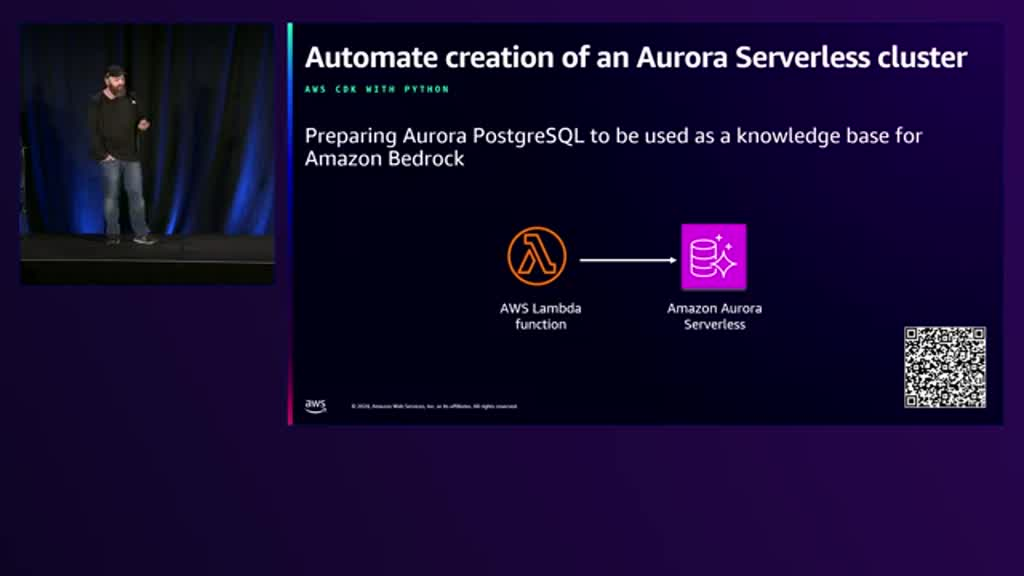

{'id': '8582157a-67af-4f15-bcdd-de00f942cc0f', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/470.jpg
filename:  470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/470.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/470.jpg', 'similarity': 0.4762014698703134}



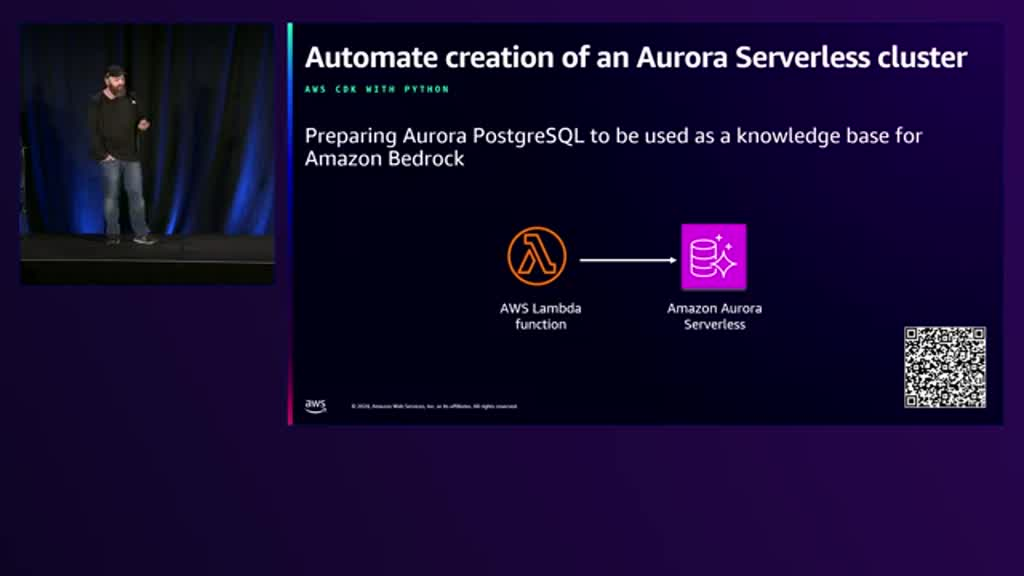

{'id': 'f0865061-00e1-4884-acf0-c0c534fe1ad7', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/429.jpg
filename:  429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}



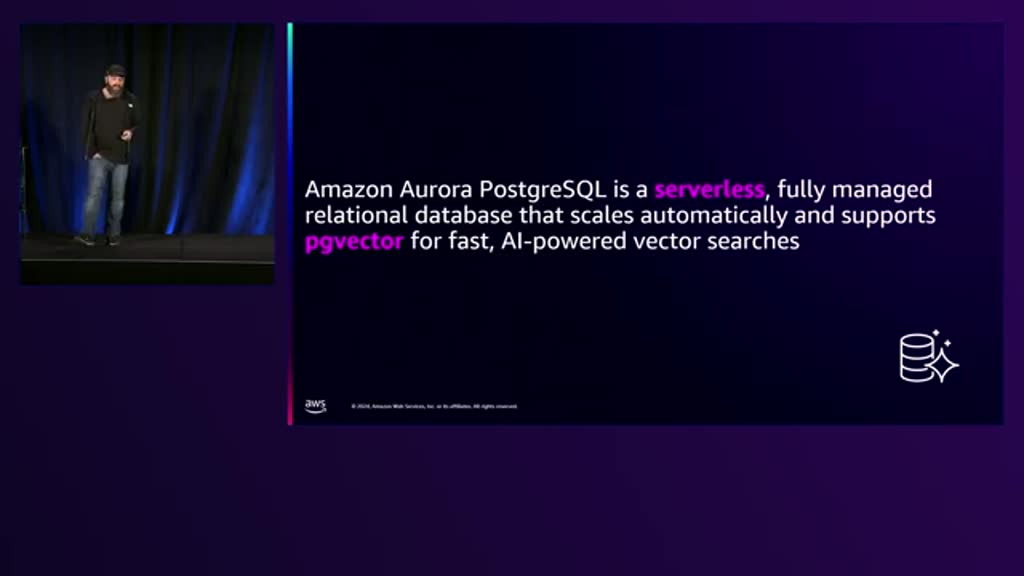

{'id': '6a374a4c-5ed3-43d4-bacc-cd9be8efef85', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/429.jpg
filename:  429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/429.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/429.jpg', 'similarity': 0.46883082780238583}



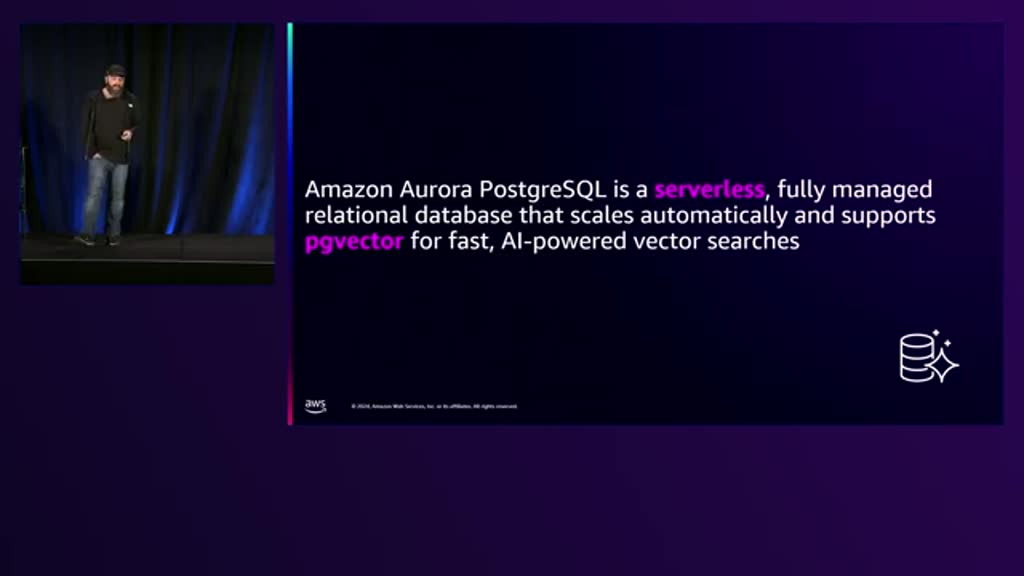

{'id': '1aa806ab-c735-4bf0-a5dd-76422c1cef89', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/600.jpg
filename:  600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}



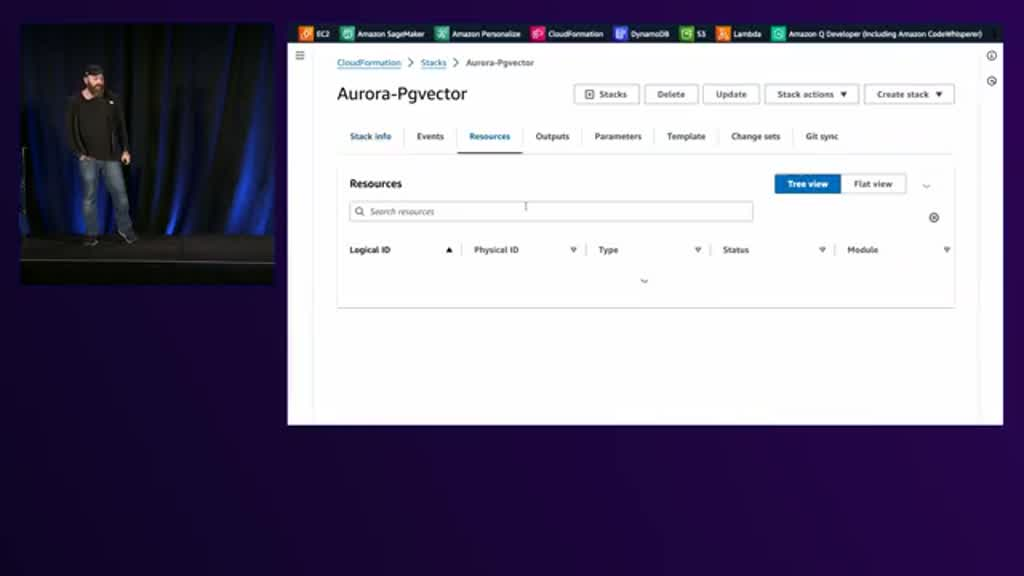

{'id': 'fc794c02-f43f-4cd7-aa96-f6cf5557886d', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/600.jpg
filename:  600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/600.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/600.jpg', 'similarity': 0.4490743906964476}



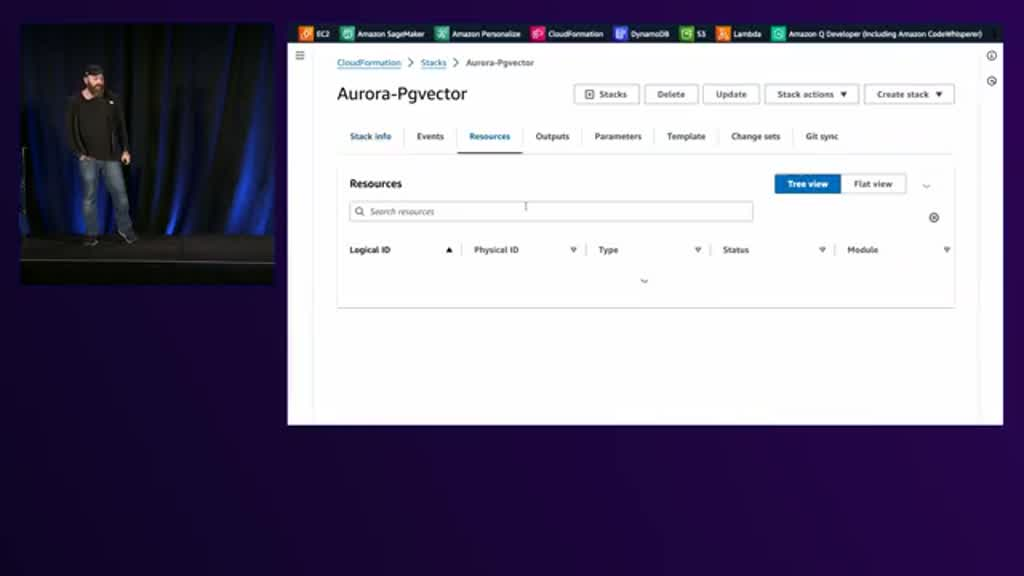

text:
None
metadata:{'speaker': 'spk_0', 'content_type': 'text', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4', 'similarity': 0.43781964749570235}

text:
None
metadata:{'speaker': 'spk_0', 'content_type': 'text', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4', 'similarity': 0.43781964749570235}

{'id': '20d01e62-c656-4095-9f81-e6c6eb28e7a3', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/2021.jpg
filename:  2021.jpg
Download file from s3://workflow-stack-videob

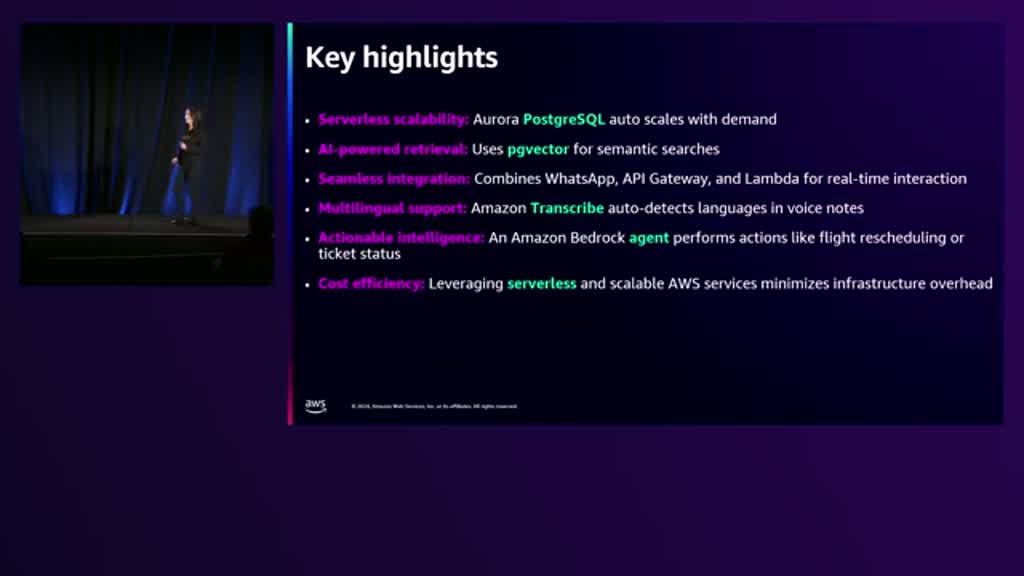

{'id': '70179630-1455-486b-a7df-e5b05ad47abf', 'metadata': {'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069}, 'page_content': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'type': 'Document'}
s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg
bucket_name:  workflow-stack-videobucket6ed8e1af-ewolhv1n69j1
key:  video/dev315.mp4/selected_frames/2021.jpg
filename:  2021.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/2021.jpg
Download file from s3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1video/dev315.mp4/selected_frames/2021.jpg
Image:
None
metadata:{'content_type': 'image', 'source': 's3://workflow-stack-videobucket6ed8e1af-ewolhv1n69j1/video/dev315.mp4/selected_frames/2021.jpg', 'similarity': 0.4252384463331069

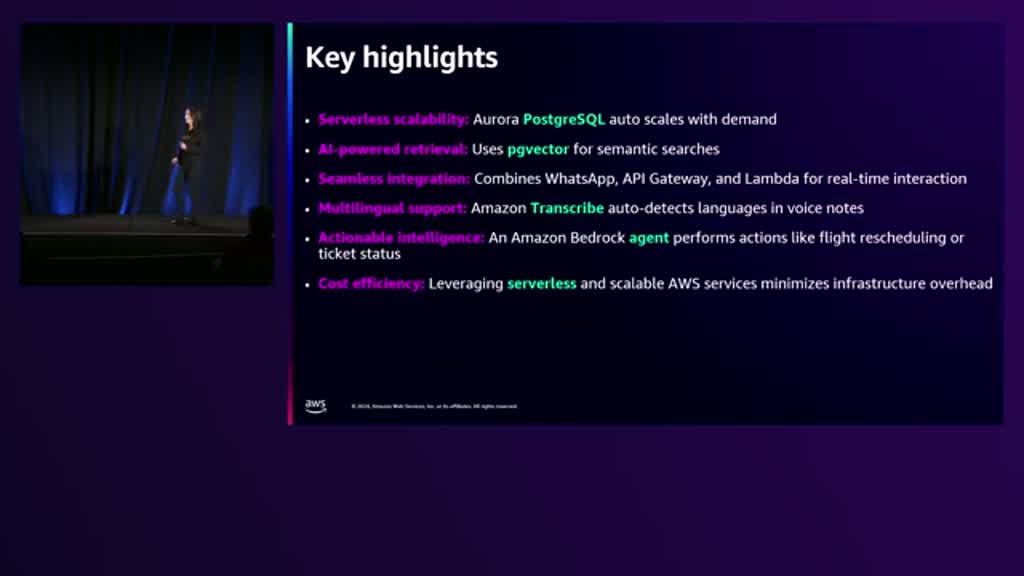

In [112]:
show_row_image_text(value['docs'])